In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from skyrim.models import FoundationModel
import datetime

In [5]:

FoundationModel.in_channel_names

In [6]:
# list all available models
FoundationModel.list_available_models()

['pangu', 'fcnv2_sm', 'graphcast', 'fcn', 'dlwp']

In [7]:
# initialize the pangu model
model = FoundationModel(model_name="pangu")

2024-04-20 23:50:04.326 | INFO     | skyrim.models:__init__:69 - Fetching pangu model package from e2mip://pangu


2024-04-20 23:50:39.086 | SUCCESS  | skyrim.models:__init__:74 - Loaded pangu model in 34.8 seconds


In [8]:
model.in_channel_names

['z1000',
 'z925',
 'z850',
 'z700',
 'z600',
 'z500',
 'z400',
 'z300',
 'z250',
 'z200',
 'z150',
 'z100',
 'z50',
 'q1000',
 'q925',
 'q850',
 'q700',
 'q600',
 'q500',
 'q400',
 'q300',
 'q250',
 'q200',
 'q150',
 'q100',
 'q50',
 't1000',
 't925',
 't850',
 't700',
 't600',
 't500',
 't400',
 't300',
 't250',
 't200',
 't150',
 't100',
 't50',
 'u1000',
 'u925',
 'u850',
 'u700',
 'u600',
 'u500',
 'u400',
 'u300',
 'u250',
 'u200',
 'u150',
 'u100',
 'u50',
 'v1000',
 'v925',
 'v850',
 'v700',
 'v600',
 'v500',
 'v400',
 'v300',
 'v250',
 'v200',
 'v150',
 'v100',
 'v50',
 'msl',
 'u10m',
 'v10m',
 't2m']

In [5]:
# lets predict the next state
first_state = model.predict_one_step(start_time=datetime.datetime(2018, 1, 1))
print(first_state.shape)

2024-04-20 21:37:46.716 | INFO     | skyrim.inference:run_basic_inference:20 - Fetching initial conditions from data source
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(2, 1, 69, 721, 1440)


In [6]:
# lets predict the next 10 states
final_state, output_paths = model.rollout(
    start_time=datetime.datetime(2018, 1, 1), n_steps=10
)

2024-04-20 21:38:16.019 | INFO     | skyrim.inference:run_basic_inference:20 - Fetching initial conditions from data source
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
2024-04-20 21:38:17.964 | INFO     | skyrim.models:save_output:176 - Saving outputs to /root/skyrim/outputs/pangu/pangu__cds__20180101_00:00__20180101_06:00.nc
2024-04-20 21:38:18.745 | SUCCESS  | skyrim.models:save_output:184 - outputs saved to /root/skyrim/outputs/pangu/pangu__cds__20180101_00:00__20180101_06:00.nc
2024-04-20 21:38:18.747 | SUCCESS  | skyrim.models:rollout:152 - Rollout step 1/10 completed
2024-04-20 21:38:18.748 | INFO     | skyrim.inference:run_basic_inference:22 - Using provided initial conditions
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
2

In [7]:
import xarray as xr

first_state_loaded = xr.open_dataarray(output_paths[0])
print(first_state_loaded.shape)

(2, 1, 69, 721, 1440)


In [9]:
second_state = xr.open_dataarray(output_paths[1])
print(second_state.shape)
print(second_state.time.values)

(2, 1, 69, 721, 1440)
['2018-01-01T06:00:00.000000000' '2018-01-01T12:00:00.000000000']


In [10]:
second_state_cds = model.predict_one_step(start_time=datetime.datetime(2018, 1, 1, 6))
print(second_state_cds.shape)
print(second_state_cds.time.values)

2024-04-20 21:40:06.674 | INFO     | skyrim.inference:run_basic_inference:20 - Fetching initial conditions from data source
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(2, 1, 69, 721, 1440)
['2018-01-01T06:00:00.000000000' '2018-01-01T12:00:00.000000000']


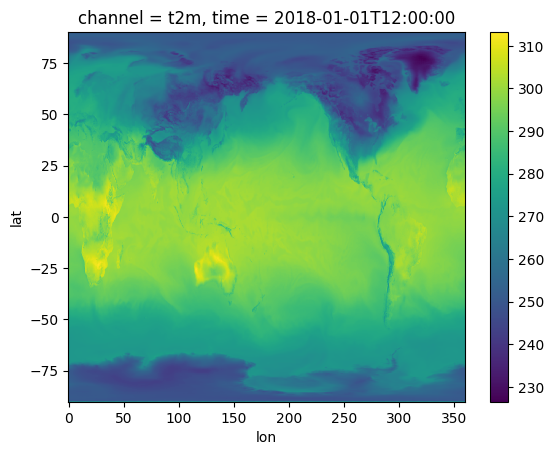

In [11]:
second_state.isel(time=1).sel(channel="t2m").squeeze().plot()

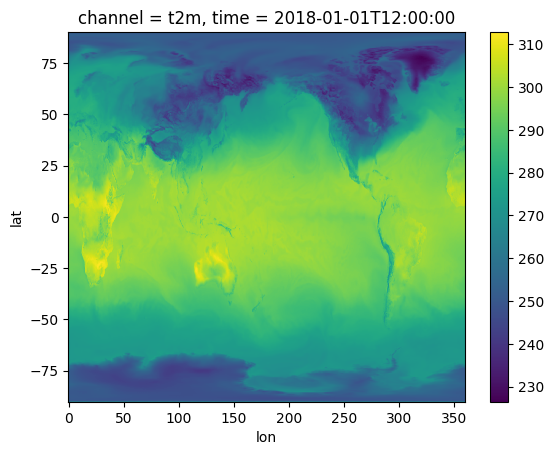

In [12]:
second_state_cds.isel(time=1).sel(channel="t2m").squeeze().plot()

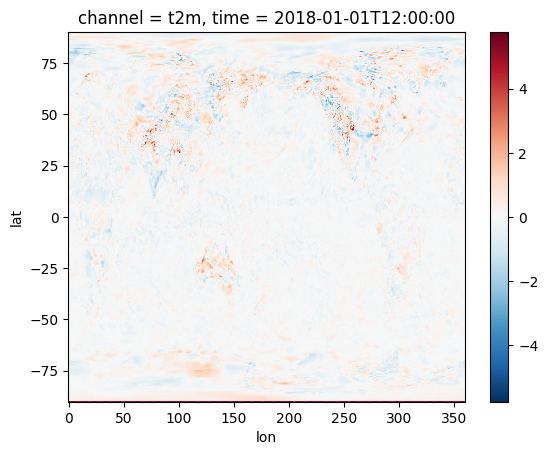

In [13]:
second_state_diff = second_state - second_state_cds
second_state_diff.isel(time=1).sel(channel="t2m").squeeze().plot()

In [19]:
def describe_t2m_diff(cds_da, model_da):
    diff = model_da - cds_da
    print(diff.isel(time=1).sel(channel="t2m").squeeze().max().item())
    print(diff.isel(time=1).sel(channel="t2m").squeeze().min().item())
    print(diff.isel(time=1).sel(channel="t2m").squeeze().mean().item())
    print(diff.isel(time=1).sel(channel="t2m").squeeze().std().item())


describe_t2m_diff(second_state_cds, second_state)

5.763519287109375
-4.4681854248046875
-0.009515568614006042
0.421856164932251


In [35]:
import pandas as pd

tenth_state = xr.open_dataarray(output_paths[-1])
# Convert the first datetime64 value to a datetime.datetime object
tenth_state_start_time = pd.to_datetime(tenth_state.time.values[0]).to_pydatetime()
eleventh_state_start_time = pd.to_datetime(tenth_state.time.values[1]).to_pydatetime()

tenth_state_cds = model.predict_one_step(start_time=tenth_state_start_time)
eleventh_state_cds = model.predict_one_step(start_time=eleventh_state_start_time)

2024-04-20 21:56:56.096 | INFO     | skyrim.inference:run_basic_inference:20 - Fetching initial conditions from data source
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
2024-04-20 21:56:58,544 INFO Welcome to the CDS
2024-04-20 21:56:58,546 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-20 21:56:58,580 INFO Welcome to the CDS
2024-04-20 21:56:58,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2024-04-20 21:56:58,699 INFO Request is queued
2024-04-20 21:56:59,841 INFO Request is running
2024-04-20 21:57:01,442 INFO Request is queued
2024-04-20 21:57:01,469 INFO Request is running
2024-04-20 21:57:03,838 INFO Request is completed
2024-04-20 21:57:03,840 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/c

12.099761962890625
-12.167526245117188
-0.22617332637310028
1.242662787437439


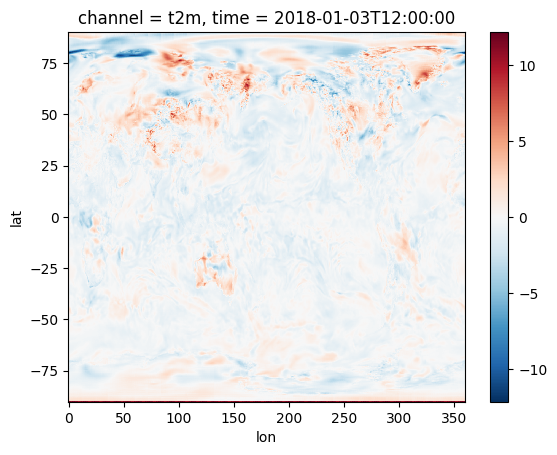

In [33]:
def plot_t2m_diff(cds_da, model_da):
    diff = model_da - cds_da
    diff.isel(time=1).sel(channel="t2m").squeeze().plot()

plot_t2m_diff(tenth_state_cds, tenth_state)
describe_t2m_diff(tenth_state_cds, tenth_state)

In [40]:
tenth_state_truth = eleventh_state_cds.isel(time=0)
print(tenth_state_truth.shape)

(1, 69, 721, 1440)


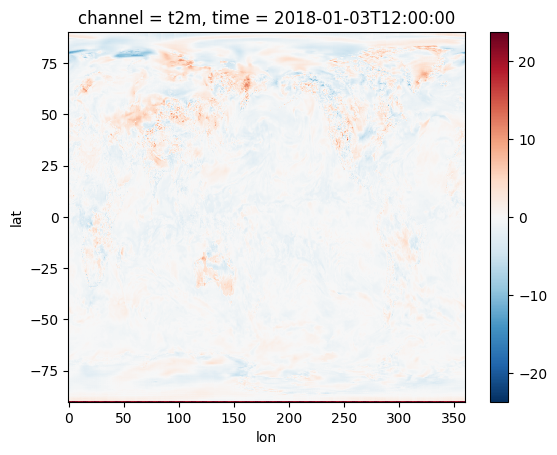

In [41]:
diff = tenth_state.isel(time=1) - tenth_state_truth
diff.sel(channel="t2m").squeeze().plot()

In [4]:
import sys
sys.path.append("..")
from skyrim.models import FoundationModel
FoundationModel.in_channel_names

ImportError: cannot import name 'FoundationModel' from 'skyrim.models' (/root/skyrim/notebooks/../skyrim/models/__init__.py)